# Feature Selection - Advanced methods
shoutout to 'Data Science With Marco' channel on youtube for this great video:
https://www.youtube.com/watch?v=hCwTDTdYirg&t=1324s

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine


In [356]:
plt.rcParams['figure.figsize'] = (12, 7)


In [357]:
wine_data = load_wine()

wine_df = pd.DataFrame(
	data=wine_data.data,
	columns=wine_data.feature_names
)

wine_df['target'] = wine_data.target

wine_df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [358]:
swarm_data = pd.melt(wine_df[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'target']], var_name='feature', value_name='value', id_vars='target')

swarm_data


,target,feature,value
0,0,alcohol,14.23
1,0,alcohol,13.20
2,0,alcohol,13.16
3,0,alcohol,14.37
4,0,alcohol,13.24
...,...,...,...
529,2,alcalinity_of_ash,20.50
530,2,alcalinity_of_ash,23.00
531,2,alcalinity_of_ash,20.00
532,2,alcalinity_of_ash,20.00


<Axes: xlabel='feature', ylabel='value'>

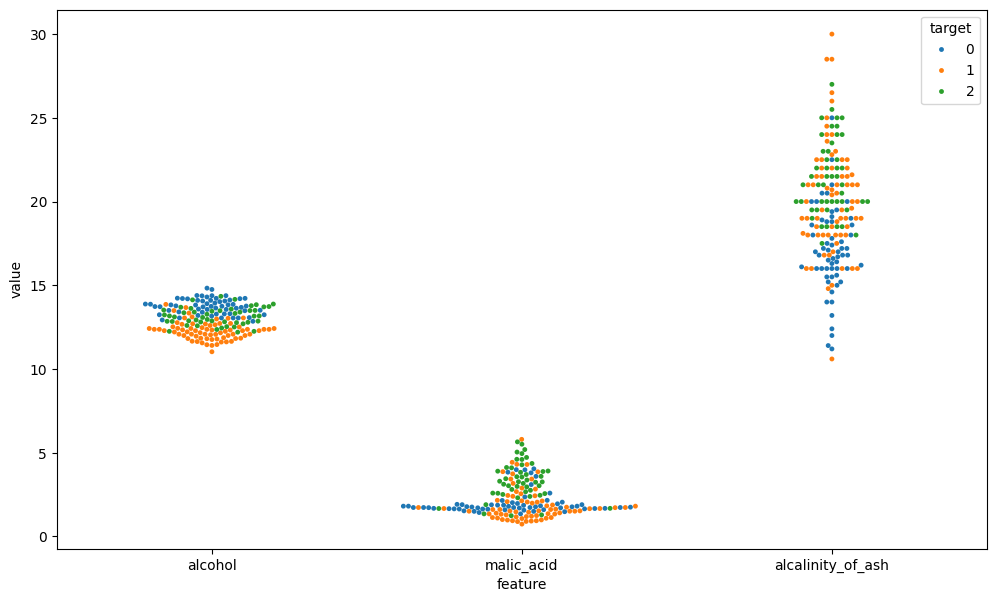

In [359]:
sns.swarmplot(
	swarm_data, x='feature', y='value', hue='target', palette='tab10', size=3.5
)


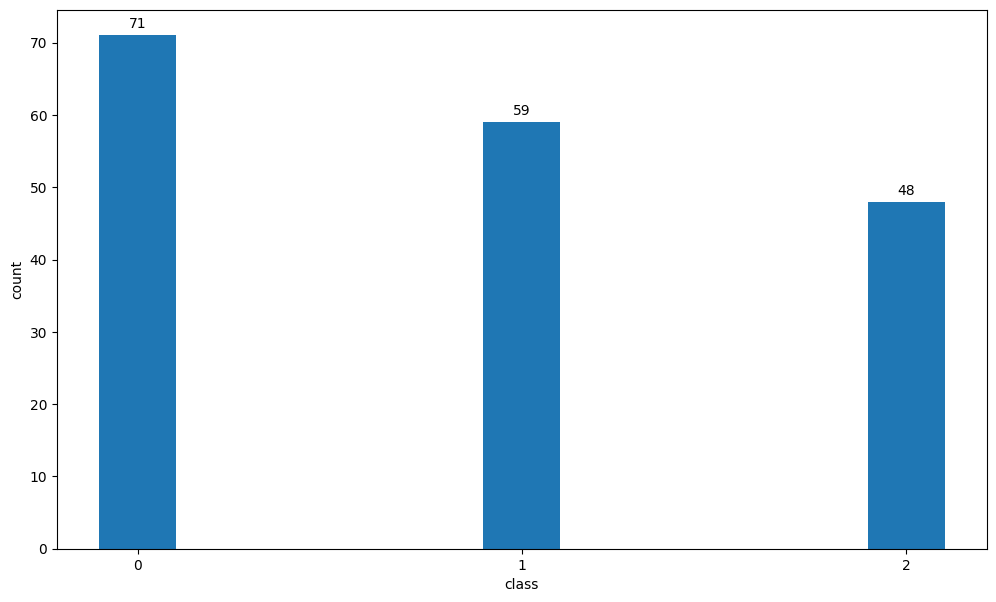

In [360]:
target_counts = wine_df['target'].value_counts()

plt.bar(range(len(target_counts)), target_counts, width=0.2)
plt.xlabel('class')
plt.ylabel('count')
plt.xticks(range(len(target_counts)))

for i, count in enumerate(target_counts):
	plt.text(x=i, y=count+1, s=str(count), ha='center')


In [361]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.3, shuffle=True, stratify=y, random_state=23
)


### Baseline model

In [362]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

model = GradientBoostingClassifier(max_depth=5, random_state=23)

# using all features
model.fit(X_train, y_train)

preds = model.predict(X_test)

score = f1_score(y_test, preds, average='weighted')
print(f'{score:.3f}')


0.908


### Feature Selection methods:
#### 1. Variance Threshold
The closer the variance of a feature is to zero, the less the model's prediction rely on that feature. And we may be able to drop that feature entirely.

In [363]:
# copy all the data
X_train_1, X_test_1, y_train_1, y_test_1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()


In [364]:
# calculate the variance of each feature(column)
# without standardization, so not scaled
X_train.var(axis=0)


alcohol                              0.688865
malic_acid                           1.256787
ash                                  0.076150
alcalinity_of_ash                   11.555056
magnesium                          188.704694
total_phenols                        0.385028
flavanoids                           0.991822
nonflavanoid_phenols                 0.016059
proanthocyanins                      0.334673
color_intensity                      5.581166
hue                                  0.054133
od280/od315_of_diluted_wines         0.463921
proline                         103265.612575
dtype: float64

In [365]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_1 = scaler.fit_transform(X_train_1)


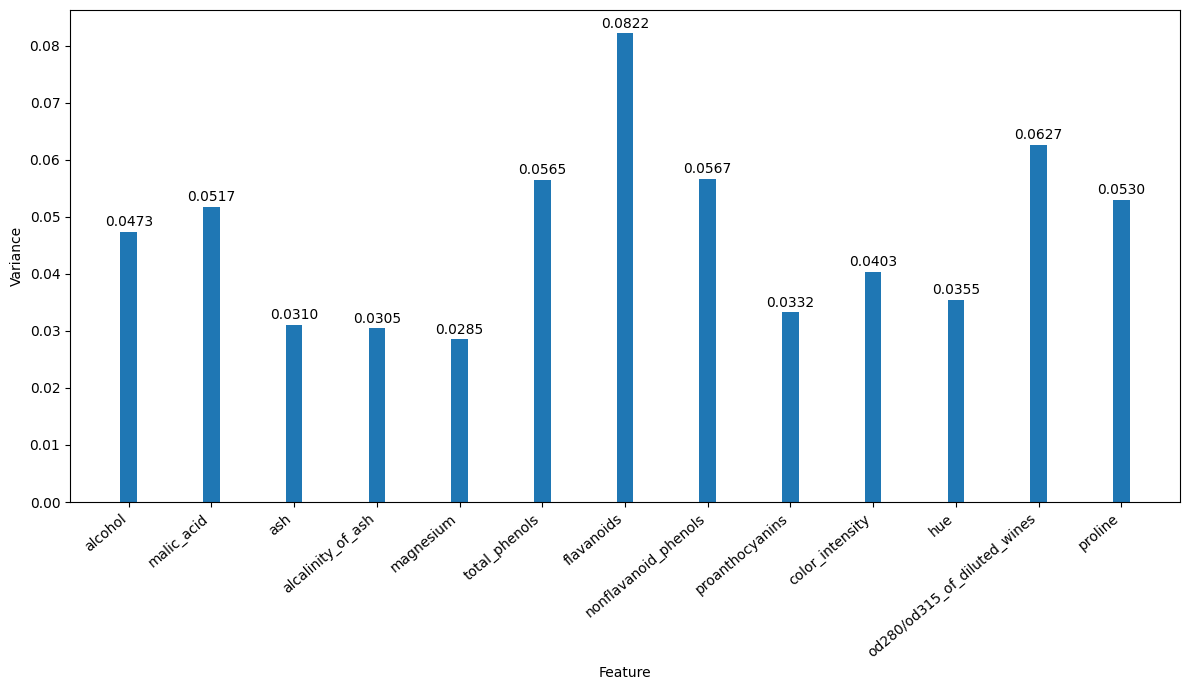

In [366]:
# plotting the new scaled variances
cols = X.columns
variances = scaled_X_train_1.var(axis=0)

plt.bar(cols, variances, width=0.2)
plt.xlabel('Feature')
plt.ylabel('Variance')

plt.xticks(rotation=40, ha='right')
plt.tight_layout()

for i, val in enumerate(variances):
	plt.text(x=i, y=val+1e-3, s=f'{val:.4f}', ha='center')


In [367]:
# if we manually set the variance threshold to something like 0.0311
var_threshold = 0.0311
features_to_drop = X.columns[variances <= var_threshold]
X_train_1 = X_train_1.drop(features_to_drop, axis=1)
X_test_1 = X_test_1.drop(features_to_drop, axis=1)
X_train_1


,alcohol,malic_acid,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
69,12.21,1.19,1.85,1.28,0.14,2.50,2.85,1.28,3.07,718.0
42,13.88,1.89,3.25,3.56,0.17,1.70,5.43,0.88,3.56,1095.0
36,13.28,1.64,2.60,2.68,0.34,1.36,4.60,1.09,2.78,880.0
116,11.82,1.47,1.98,1.60,0.30,1.53,1.95,0.95,3.33,495.0
165,13.73,4.36,1.28,0.47,0.52,1.15,6.62,0.78,1.75,520.0
...,...,...,...,...,...,...,...,...,...,...
72,13.49,1.66,1.88,1.84,0.27,1.03,3.74,0.98,2.78,472.0
16,14.30,1.92,2.80,3.14,0.33,1.97,6.20,1.07,2.65,1280.0
15,13.63,1.81,2.85,2.91,0.30,1.46,7.30,1.28,2.88,1310.0
151,12.79,2.67,1.48,1.36,0.24,1.26,10.80,0.48,1.47,480.0


In [354]:
# now let's test the new features
model.fit(X_train_1, y_train_1)

preds = model.predict(X_test_1)

score = f1_score(y_test_1, preds, average='weighted')

print(f'{score:.3f}')


0.854


#### 2. KBest Features